# Notes

This assignment is partially autograded. Problems 2 and 3 are graded manually according to the following rules:

- **1 point**: attempt was made, but solution is not correct,
- **2 points**: solution is generally correct, but is not efficient/has unreasonably low performance,
- **3 points**: solution is correct, is efficient/has reasonably high performance *(maximum grade for Problem 3)*.

Problem 1 is auto-graded. The maximum grade is **2 points** for Problem 2 and **3 points** for Problem 3.

In [1]:
%pylab inline
plt.style.use("bmh")

Populating the interactive namespace from numpy and matplotlib


In [2]:
plt.rcParams["figure.figsize"] = (6,6)

In [3]:
import numpy as np
import torch
from sklearn import datasets

In [4]:
STUDENT = "Alon Cohen"
ASSIGNMENT = 3
TEST = False

In [5]:
if TEST:
    import solutions
    total_grade = 0
    MAX_POINTS = 6

# Gradients

### 1. Generate gradient (1 point).

For 2-dimensional tensor `tr`, calculate a gradient of $\sum\log tr_{ij}$. Note, that you're provided with dimensions and interval, and not the `tr` inself:

- `dims` is a tuple, so that `tr.size()` equals `dims`,
- `lims` is an interval, so that elements of `tr` are integeres, uniformly sampled from `[lims[0], lims[1])` interval (note, that lims[1] is **not** included).

Result must be a tensor of the same shape as `tr` (namely, `dims`), containing gradients of the following function:

$$\sum_{ij}\log tr_{ij}.$$

and generated `tr` itself.

Result **will be tested against multiple random combinations of input tensor dimensions ($10 \leq n < 100 $) and sampling interval (`lims[0]=1`, `10 <= lims[1] < 100`)**.

**Hint**: think on how you can validate the solution yourself, given that gradient can be computed manually on paper.

In [6]:
def generate_grad(dims, lims):
    
    tr = torch.distributions.Uniform(lims[0], lims[1]).sample(dims)
    tr.requires_grad=True
    
    x = torch.log(tr).sum()
    x.backward()

    return tr.grad, tr

In [7]:
PROBLEM_ID = 1

if TEST:
    total_grade += solutions.check(STUDENT, PROBLEM_ID, generate_grad)

### 2. Find a minimum (2 points, manually graded).

Consider the following scalar function:

$$
f(x) = ax^2 + bx + c
$$

Given the $a,b,c$, find $x$, which minimizes $f(x)$. Note this:

- $a,b,c$ are fixed, and generated in such a way, that minimum always exists ($f(x)$ is convex),
- $x$ is a scalar value, i.e. 0-dimensional tensor.

**Hint:** stop for a second to think about which tensor must contain `requires_grad` and on which scalar should `.backward()` be called.

In [8]:
def generate_coeffs():
    a = torch.rand(size=()) * 10
    b = -10 + torch.rand(size=()) * 10
    c = -10 + torch.rand(size=()) * 10
    return a, b, c

def func(x, a, b, c):
    return x.pow(2) * a + x * b + c

In [50]:
EPOCHS = 100
LR = 1e-1
STARTING_VAL = 20. # Consider choosing different starting values for x to speed-up the optimization

# Initialize x, a, b, c
x = torch.tensor(STARTING_VAL, requires_grad=True)
a, b, c = generate_coeffs()

# Collect f(x) values during training for visuzalition later on
f_vals = []

for i in range(EPOCHS):
    y = func(x, a, b, c)
    
    y.backward()
    with torch.no_grad():
        x.sub_(LR * x.grad)
    x.grad.zero_()
    f_vals.append(y)
    
    try:
        if f_vals[-1] >= f_vals[-2]:
            break
    except:   
        pass
    print(f"Epoch {i}: x = {x}, y value = {f_vals[-1]}")
    


Epoch 0: x = -2.0324630737304688, y value = 2140.080078125
Epoch 1: x = 0.8106343746185303, y value = 26.135032653808594
Epoch 2: x = 0.4437570869922638, y value = -9.065641403198242
Epoch 3: x = 0.49109944701194763, y value = -9.651792526245117
Epoch 4: x = 0.48499035835266113, y value = -9.661552429199219
Epoch 5: x = 0.48577865958213806, y value = -9.661715507507324
Epoch 6: x = 0.48567694425582886, y value = -9.661718368530273


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

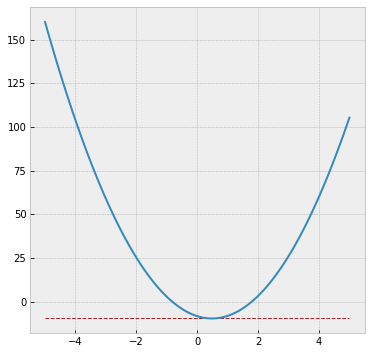

In [51]:
if f_vals:
    grid = np.linspace(-5, 5, 100)
    plt.plot(grid, np.square(grid) * a.item() + grid * b.item() + c.item())
    plt.hlines(f_vals[-1], -5, 5, "firebrick", "--", linewidth=1)

In [11]:
PROBLEM_ID = 2
GRADE = 0

if TEST:
    total_grade += GRADE

### 3. Simple neural network model (3 points, manually graded).

Construct a non-linear model for binary classification. Use logistic regression example from Week 3 lecture as a blueprint. Experiment with different number of intermediate layers and their sizes to achieve good performance.

For a reference, imagine a neural network with a single hidden layer with $N$ neurons. Then, input $X$ is first transformed as:

$$
X^{hidden}_{ik} = \sigma(X_{ij}W^{hidden}_{jk} + b^{hidden}_k),
$$
$$
\hat y_{i} = \sigma(X^{hidden}_{ij}W_{j} + b).
$$

After this, $X^{hidden}_{ik}$ can be considered as an input to the same logistic regression model we had in class. The bonus is that we performed non-linear transformation of the original coordinates and can now catch non-linear decision boundary (as is the case for the mock data below).

Note also, that $X$ has shape $(N, 2)$ (where $N$ is the number of training examples), $W^{hidden}_{jk}$ has shape of $(2, N^{hidden})$ and $b^{hidden}_k$ has shape $(N^{hidden})$. At the same time, $W$ has shape $(N^{hidden},)$ and $b$ is a scalar (the same way it was for logistic regression). This model can be considered as a logistic regression on transformed coordinates, but we learn the transformation itself.

**Validation criterion for full grade on this problem:** achieve accuracy of at least `0.94` **and** use no more than one hidden layer with no more than 6 neurons.

In [36]:
N_LAYERS = 1
N_HIDDEN = (6,)

In [37]:
X, y = datasets.make_moons(1000, noise=.25)

In [38]:
Xt = torch.tensor(X, dtype=torch.float)
yt = torch.tensor(np.expand_dims(y, axis=-1), dtype=torch.float)

In [39]:
weights = []
biases = []

# any setup code you need

for i in range(N_LAYERS):
    # Initialize w and b for layer i with number of "neurons" of N_HIDDEN[i]
    w = torch.randn(2,N_HIDDEN[i], requires_grad=True)
    b = torch.randn(1,N_HIDDEN[i], requires_grad=True)
    weights.append(w)
    biases.append(b)

weights.append(torch.randn(N_HIDDEN[-1],1, requires_grad=True))
biases.append(torch.randn(1,1, requires_grad=True))

In [40]:
def sigmoid(a):
    """Sigmoid activation function."""

    return 1/(1 + (-a).exp())

def output(X, weights, biases):
  X_hidden = X
  W_hidden,b_hidden = weights[0:-1],biases[0:-1]
  W_result,b_result = weights[-1],biases[-1]
  for W, b in zip(W_hidden, b_hidden):
    X_hidden = sigmoid(torch.mm(X_hidden,W) + b)
  return sigmoid(torch.mm(X_hidden,W_result) + b_result)

def logloss(y, y_pred):
    return -(y * torch.log(y_pred) + (1 - y) * torch.log(1 - y_pred)).mean()

In [41]:
EPOCHS = 10000
LR = 6e-1
DELTA = 0.0000000000000001
loss_history = []

for i in range(EPOCHS):
    y_pred = output(Xt, weights, biases)
    loss = logloss(yt, y_pred)
    loss.backward()
    loss_history.append(loss.item())
    
    for W,b in zip(weights, biases):
      with torch.no_grad():
        W.sub_(LR * W.grad)
        b.sub_(LR * b.grad)
      W.grad.zero_()
      b.grad.zero_()

    # wipe out all gradients
    # your code goes here

    if i % 1000 == 0:
        print(f"Epoch {i}: loss = {loss_history[-1]}")
    
    try:
        if loss_history[-2] - loss_history[-1] < DELTA:
            break
    except:
        pass


Epoch 0: loss = 0.9496275782585144
Epoch 1000: loss = 0.2238457351922989
Epoch 2000: loss = 0.1828155219554901
Epoch 3000: loss = 0.17076925933361053
Epoch 4000: loss = 0.1653718650341034
Epoch 5000: loss = 0.16209618747234344
Epoch 6000: loss = 0.15997852385044098
Epoch 7000: loss = 0.15862280130386353
Epoch 8000: loss = 0.157755047082901
Epoch 9000: loss = 0.1571866124868393


In [42]:
accuracy = np.sum(y == (y_pred.detach().numpy().flatten() > 0.5))/1000
print("Accuracy is %f" % accuracy)

Accuracy is 0.945000


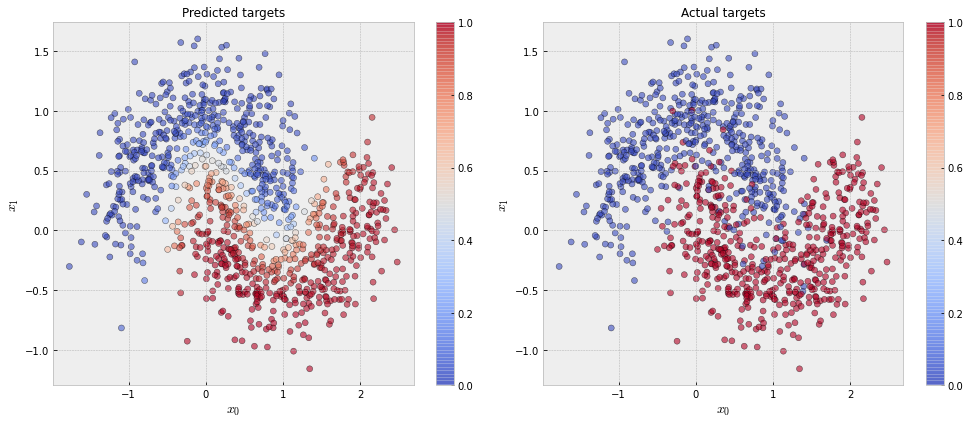

In [43]:
plt.figure(figsize=(14,6))

plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c=y_pred.detach().numpy().flatten(), alpha=0.6, edgecolor='k',
            cmap=plt.cm.coolwarm, vmin=0, vmax=1)
plt.colorbar()
plt.xlabel('$x_0$', fontsize=14)
plt.ylabel('$x_1$', fontsize=14)
plt.title("Predicted targets", fontsize=12)

plt.subplot(1, 2, 2)
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.6, edgecolor='k',
            cmap=plt.cm.coolwarm, vmin=0, vmax=1)
plt.colorbar()
plt.xlabel('$x_0$', fontsize=14)
plt.ylabel('$x_1$', fontsize=14)
plt.title("Actual targets", fontsize=12)
plt.tight_layout()

In [ ]:
PROBLEM_ID = 3
GRADE = 0

if TEST:
    total_grade += GRADE

In [ ]:
if TEST:
    print(f"{STUDENT}: {int(100 * total_grade / MAX_POINTS)}")